# Streaming Gaussian Mixture Model

## Updating the model when a new object arrives

### General idea

Let $X_1 = \{ x_1, \dotsc, x_N \}$ a collection of $N$ data points generated iid according to a distribution $p(x \mid \Theta)$ given parameter(s) $\Theta$. By Bayes theorem, the _posterior distribution_ of $\Theta$ given $X_1$ is

\begin{equation}
p(\Theta \mid X_1) \propto p(X_1 \mid \Theta)p(\Theta)
\end{equation}

Now, if we want to estimate the posterior of a new collection $X_2 = \{ x_{N+1}, \dotsc, x_{2N} \}$ of data points, the update would be

\begin{align}
p(\Theta \mid X_2, X_1) &\propto p(X_2, X_1 \mid \Theta)p(\Theta) \\
p(\Theta \mid X_2, X_1) &\propto p(X_2 \mid \Theta)p(X_1 \mid \Theta)p(\Theta) \\
p(\Theta \mid X_2, X_1) &\propto p(X_2 \mid \Theta)p(\Theta \mid X_1)
\end{align}

Then, the posterior of collection $b$, after seeing $b - 1$ collection is

\begin{equation}
p(\Theta \mid X_b, \dotsc, X_1) \propto p(X_b \mid \Theta)p(\Theta \mid X_{b-1}, \dotsc, X_1)
\end{equation}.

Following [1], we assume that we approximate the posterior using 
*variational inference*. That is, we assume that we can approximate the posterior of a collection of points with a function $q$, such that

\begin{align}
p(\Theta \mid X_b) \propto q_b(\Theta)
\end{align}

Also, we assume that $p(\Theta)$ is an exponential family distribution for $\Theta$ with sufficients statistic $T(\Theta)$ and natural parameter $\xi_0$. We suppose further that if $q(\Theta)$ is the approximate posterior obtained using variational inference, then $q(\Theta)$ is also in the same exponential family, with natural parameter $\xi$ such that

\begin{equation}
q(\Theta) \propto \text{exp}(\xi \cdot T(\Theta))
\end{equation}

When we make this assumptions, the update for $b$ collections is 

\begin{align}
p(\Theta \mid X_b, \dotsc, X_1) &\propto \left [\prod_{i=1}^B p(X_i \mid \Theta)\right ]p(\Theta) \\ 
p(\Theta \mid X_b, \dotsc, X_1) &\propto \left [\prod_{i=1}^B p(\Theta \mid X_i)p(\Theta)^{-1} \right ]p(\Theta) \\
p(\Theta \mid X_b, \dotsc, X_1) &\approx \left [\prod_{i=1}^B q_i(\Theta)p(\Theta)^{-1} \right ]p(\Theta) \\
p(\Theta \mid X_b, \dotsc, X_1) &\approx \text{exp} \left (\left [\xi_0 + \sum_{i=1}^B (\xi_b - \xi_0) \right ] \cdot T(\Theta) \right) \\
\end{align}.

### Mixture of GMM update

The mean field approximation for the GMM is

\begin{equation}
p(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda} \mid X) \approx q(\boldsymbol{\pi})q(\boldsymbol{\mu}, \boldsymbol{\Lambda})
\end{equation}

where 

\begin{align}
q(\boldsymbol{\pi}) &= Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha}) \\
q(\boldsymbol{\mu}, \boldsymbol{\Lambda}) &= \mathcal{N}(\boldsymbol{\mu} \mid \mathbf{m}, (\beta\boldsymbol{\Lambda})^{-1})\mathcal{W}(\boldsymbol{\Lambda} \mid \mathbf{W}, \nu)
\end{align}

#### Dirichlet update

The natural parameter for the dirichlet is:

\begin{equation}
\xi = \boldsymbol{\alpha}_k - 1
\end{equation}

hence, the update is:

\begin{equation}
\boldsymbol{\alpha}_k' \leftarrow \boldsymbol{\alpha}_k + (\boldsymbol{\alpha}_k^{\star} - \boldsymbol{\alpha}_0)
\end{equation}

#### Normal-Wishart update

The natural parameter for the Normal-Wishart distribution is:

\begin{equation}
\xi = \begin{bmatrix}
       \beta_k\boldsymbol{m}_k           \\[0.3em]
       \beta_k \\[0.3em]
       \boldsymbol{W}_k^{-1} + \beta\boldsymbol{m}_k\boldsymbol{m}_k^T \\[0.3em]
       \nu_k + 2 + p
     \end{bmatrix}
\end{equation},

hence, the updates are:

\begin{align}
\beta_k' &\leftarrow \beta_k + (\beta_k^{\star} - \beta_0) \\
\boldsymbol{m}_k' &\leftarrow \frac{1}{\beta_k'}(\beta_k\boldsymbol{m}_k + (\beta_k^{\star}\boldsymbol{m}_k^{\star} - \beta_0\boldsymbol{m}_0) \\
\boldsymbol{W}_k^{-1} &\leftarrow (\boldsymbol{W}_k^{-1} + \beta_k\boldsymbol{m}_k\boldsymbol{m}_k^T) + (\boldsymbol{W}_k^{-1\star} + \beta_k^{\star}\boldsymbol{m}_k^{\star}\boldsymbol{m}_k^{T\star}) - \beta_k\boldsymbol{m}_k\boldsymbol{m}_k^T \\
\nu_k' &\leftarrow \nu_k + (\nu_k^{\star} - \nu_0) \\
\end{align}


## Current problems

* Component identification

## References

[1]: Tamara Broderick, Nicholas Boyd, Andre Wibisono, Ashia C. Wilson, and Michael I. Jordan. 2013. Streaming variational bayes. In Proceedings of the 26th International Conference on Neural Information Processing Systems (NIPS'13), C. J. C. Burges, L. Bottou, M. Welling, Z. Ghahramani, and K. Q. Weinberger (Eds.). Curran Associates Inc., , USA, 1727-1735.

## Synthetic data generation

In the cell below we are going to generate synthetic data from multiple GMMs (one GMM per class).

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import invwishart
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from src.experiments.data.synthetic import GMMDataGenerator

import logging
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger(__name__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(732839717)

sns.set(rc={"figure.figsize": (6, 6)})

CLASS_COLORS = ['#66c2a5',
                '#fc8d62',
                '#8da0cb',
                '#e78ac3',
                '#a6d854',
                '#ffd92f',
                '#e5c494',
                '#b3b3b3']

In [2]:
GMMDataGenerator

src.experiments.data.synthetic.GMMDataGenerator

In [3]:
def plot_gmm_obs(X, C, title='', ax=None):
    xlabel = 'x'
    ylabel = 'y'
    components = np.max(C) + 1
    for k in range(components):
        obs_of_k_component = np.where(C == k)[0]
        if ax:
            ax.scatter(X[obs_of_k_component, 0], X[obs_of_k_component, 1], 
                    facecolor=CLASS_COLORS[k], alpha=0.5,
                    edgecolor='black', linewidth=0.15)
        else:
            plt.scatter(X[obs_of_k_component, 0], X[obs_of_k_component, 1], 
                    facecolor=CLASS_COLORS[k], alpha=0.5,
                    edgecolor='black', linewidth=0.15)
    if ax:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    else:
        plt.title(title)
        #plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)


In [4]:
pal = sns.light_palette((200, 75, 60), input="husl", as_cmap=True)

def plot_gmm(X, mu, W, ax=None):
    assert mu.shape[0] == W.shape[0]
    dims = mu.shape[0]
    
    if ax:
        ax.scatter(X[:, 0], X[:, 1], 
                    alpha=0.5,
                    edgecolor='black', linewidth=0.15)
    else:
        plt.scatter(X[:, 0], X[:, 1], 
                    alpha=0.5,
                    edgecolor='black', linewidth=0.15)
    min_x, min_y = np.amin(X, axis=0)
    max_x, max_y = np.amax(X, axis=0)
    x, y = np.mgrid[min_x:max_x:0.1, min_y:max_y:0.1]
    z = np.zeros(x.shape + (2,))
    z[:, :, 0] = x;
    z[:, :, 1] = y
    for i in range(mu.shape[0]):
        f_z = scipy.stats.multivariate_normal.pdf(z, mu[i, :], W[i, :])
        if ax:
            ax.contour(x, y, f_z, antialiased=True, cmap=pal)
        else:
            plt.contour(x, y, f_z, antialiased=True, cmap=pal)

In [5]:
M = 1

# Number of components per class.
K = 3

# Dimension of data.
D = 2

#np.random.seed()

synthetic_gmm = GMMDataGenerator(k=K, d=D)
print('Mu:\n', synthetic_gmm.get_mu())
print('Cov:\n', synthetic_gmm.get_cov())

Mu:
 [[-13.4976689   -9.15391219]
 [ -8.52296015 -10.78440209]
 [ -8.01447974 -11.79393004]]
Cov:
 [[[ 0.87869225 -0.30782368]
  [-0.30782368  0.63133224]]

 [[ 2.1120209   0.36474583]
  [ 0.36474583  0.28096147]]

 [[ 0.8424209   0.99595504]
  [ 0.99595504  1.65430142]]]


# New data batch generation

In the following cell we generate batches of the synthetic GMM.

In [6]:
n_batchs = 10

X_batchs = []
C_batchs = []
for i in range(n_batchs):
    new_X, new_C = synthetic_gmm.generate(n=1000)
    X_batchs.append(new_X)
    C_batchs.append(new_C)

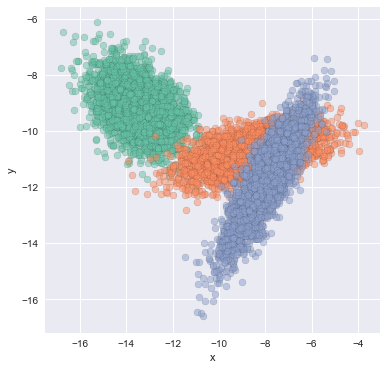

In [7]:
plot_gmm_obs(np.concatenate(X_batchs), np.concatenate(C_batchs))

In the cell bellow we can see the data generated in each batch.

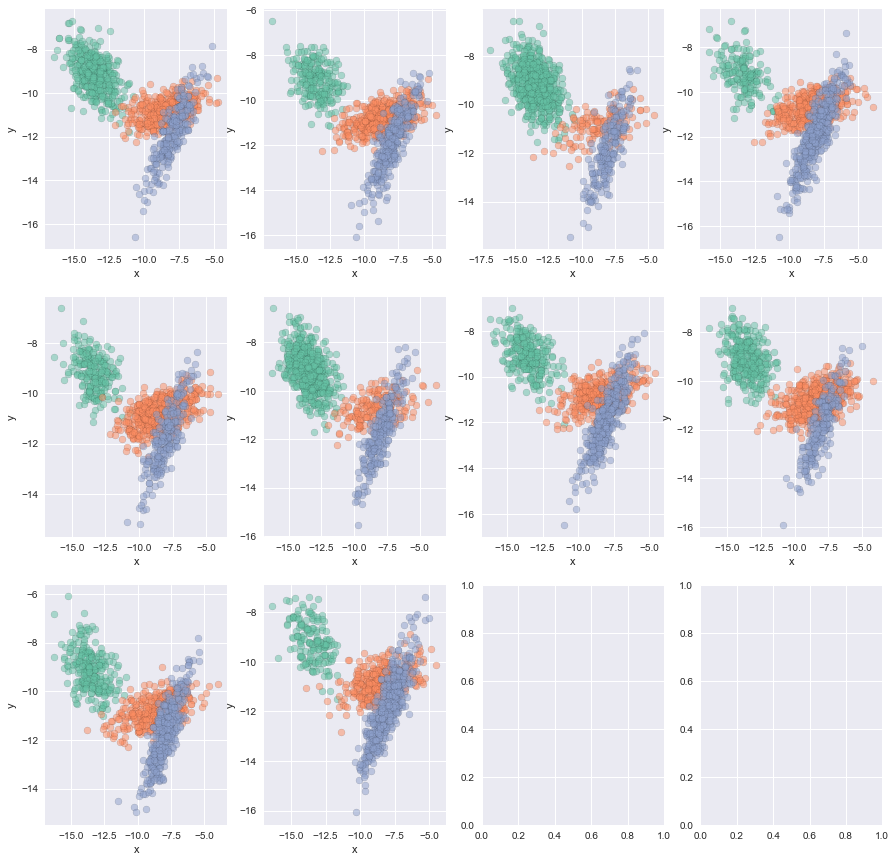

In [8]:
cols = 4
rows = n_batchs // cols + 1
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < n_batchs:
            plot_gmm_obs(X_batchs[index], 
                         C_batchs[index], 
                         ax=ax[i, j])
            #plot_gmm_obs(X_batchs[index], C_batchs[index], ax=ax[i, j])
plt.show()

In [9]:
import json

from src.streaming_gmm.streaming_variational_gmm import StreamingVariationalGMM, VariationalGMM

#prior =
#W_0 = 5 * np.eye(D)

result_list = []
debug_dict = {}
#streaming_vb_gmm = VariationalGMM(K, D)
for i in range(1, n_batchs + 1):
    logger.info('Starting batch %d', i)
    #X = np.concatenate(X_batchs[:i])
    X = X_batchs[i-1]
    #streaming_vb_gmm.update_with_new_data(X)
    vbGmm = VariationalGMM(K, D, alpha_0=.01)
    vbGmm.fit(X, max_iter=50)
    #batch_result = streaming_vb_gmm.get_checkpoint()
    result_list.append(vbGmm.get_checkpoint())
#plot_gmm(X, vbGmm.m_k, np.linalg.inv(vbGmm.nu_k[:, np.newaxis, np.newaxis]*vbGmm.W_k))


debug_dict = {'checkpoints': []}
for result in result_list:
    new_dict = {}
    for k, v in result['variational_parameters'].items():
        new_dict[k] = np.array_str(v) 
    new_dict['pi_k_expec'] = np.array_str(result['pi_k_expectation'])
    debug_dict['checkpoints'].append(new_dict)

with open('logs/variational_gmm_results.json', 'w') as outfile:
    json.dump(debug_dict, outfile)

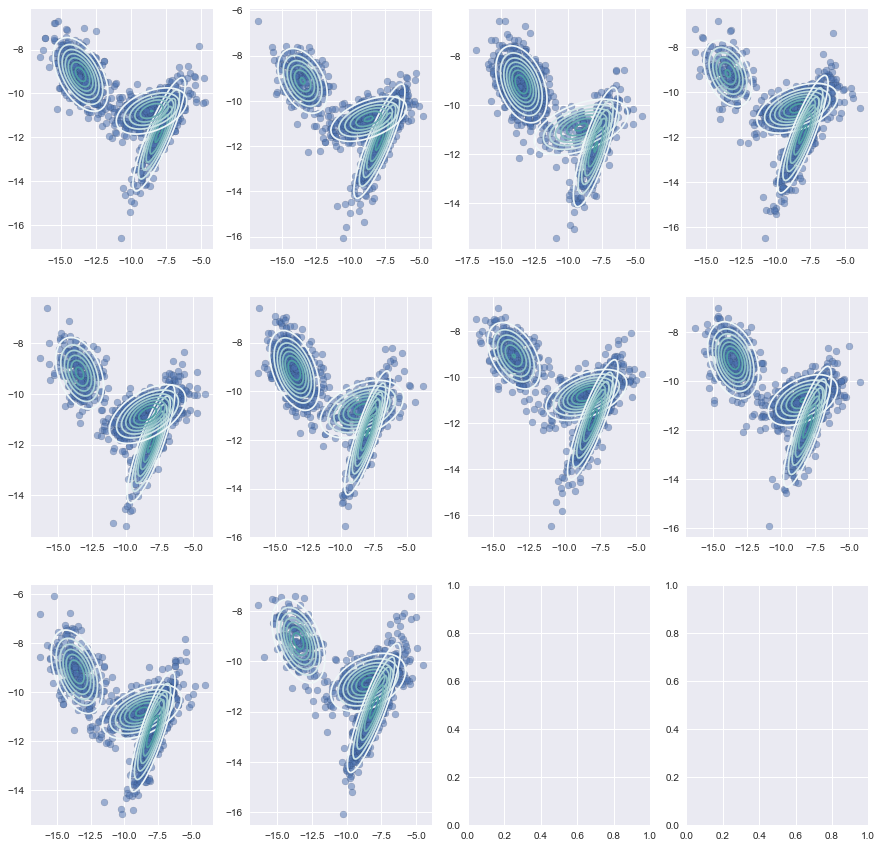

In [10]:
cols = 4
rows = n_batchs // cols + 1
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < n_batchs: 
            #X = np.concatenate(X_batchs[:index + 1])
            X = X_batchs[index]
            C = C_batchs[index]
            variational_params = result_list[index]['variational_parameters']
            m_k = variational_params['m_k']
            nu_k = variational_params['nu_k']
            W_k = variational_params['W_k']
            plot_gmm(X, 
                     m_k, 
                     np.linalg.inv(nu_k[:, np.newaxis, np.newaxis] * W_k),
                     ax=ax[i, j])
plt.show()

In [31]:
from src.streaming_gmm.streaming_variational_gmm import StreamingVariationalGMM, VariationalGMM

result_list = []
streaming_vb_gmm = StreamingVariationalGMM(K, D, max_iter=50, alpha_0=.01)
for X, C in zip(X_batchs, C_batchs): 
    streaming_vb_gmm.update_with_new_data(X)
    predictions = np.mean(streaming_vb_gmm.predict(X))
    print(predictions)
    #vbGmm = VariationalGMM(K, D)
    #vbGmm.fit(X, max_iter=20)
    #batch_result = streaming_vb_gmm.get_checkpoint()
    #result_list.append(streaming_vb_gmm.get_checkpoint())
result_list = streaming_vb_gmm.checkpoints
#plot_gmm(X, vbGmm.m_k, np.linalg.inv(vbGmm.nu_k[:, np.newaxis, np.newaxis]*vbGmm.W_k))

0.0481124294935
0.0511656080665
0.0476028271315
0.0492307042786
0.0516195926011
0.0462037576057
0.0497509572914
0.0500069000395
0.050549389556
0.0509159826341


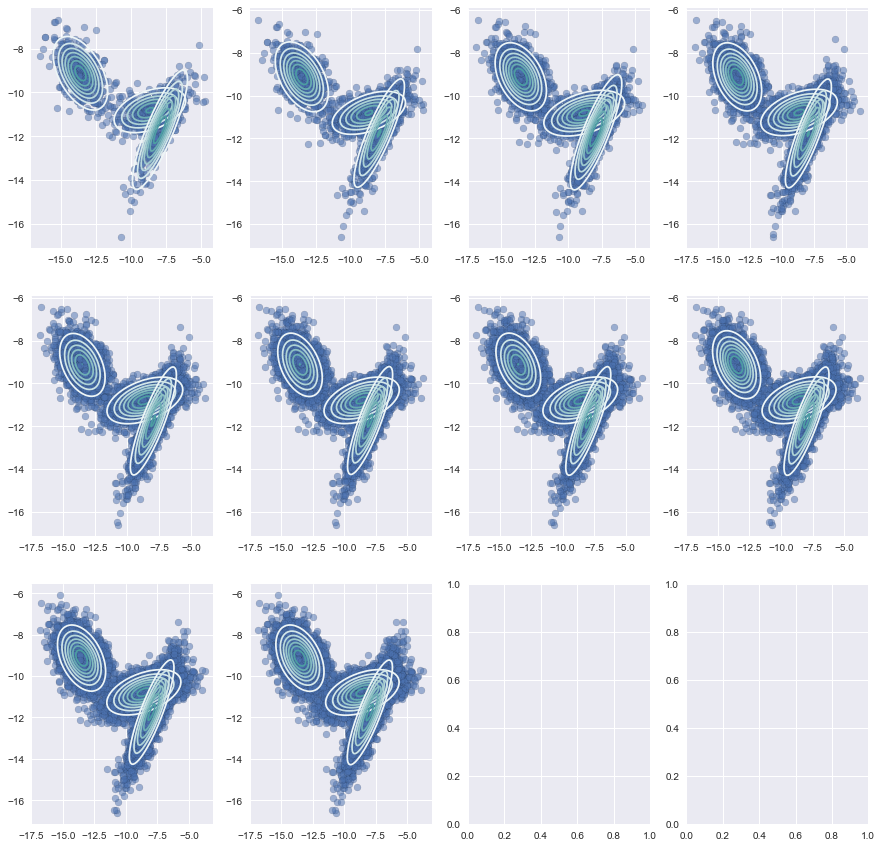

In [30]:
cols = 4
rows = n_batchs // cols + 1
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < n_batchs: 
            X = np.concatenate(X_batchs[:index + 1])
            #X = X_batchs[index]
            C = C_batchs[index]
            variational_params = result_list[index]['streaming_variational_parameters']
            m_k = variational_params['m_k']
            nu_k = variational_params['nu_k']
            W_k = variational_params['W_k']
            plot_gmm(X, 
                     m_k, 
                     np.linalg.inv(nu_k[:, np.newaxis, np.newaxis] * W_k),
                     ax=ax[i, j])
plt.show()


In [5]:
def generate_batches(generator, n_batchs, obs_per_batch):
    for i in range(n_batchs):
        yield generator.generate(n=obs_per_batch)

In [16]:
from src.streaming_gmm.streaming_variational_gmm import StreamingVariationalGMM, VariationalGMM

# Number of components per class.
K = 2

# Dimension of data.
D = 2

N_BATCHES = 200
N_PER_BATCH = [5 * (2 ** i) for i in range(1, 10)]

#N_PER_BATCH = [10]

predictions = {}

for n_per_batch in N_PER_BATCH:
    np.random.seed(732839717)
    streaming_vb_gmm = StreamingVariationalGMM(K, D, max_iter=50, alpha_0=1/K)
    generator = GMMDataGenerator(k=K, d=D)
    X_test, C_test = generator.generate(n=200)
    predictions[n_per_batch] = []
    for X_train, C_train in generate_batches(generator, N_BATCHES, n_per_batch):
        streaming_vb_gmm.update_with_new_data(X_train)
        predictive = np.mean(streaming_vb_gmm.predict(X_test))
        predictions[n_per_batch].append(np.log(predictive))

/home/lukas/proyectos/variational-gmm/src/streaming_gmm/variational_gmm.py:234: RuntimeWarning: divide by zero encountered in log
  * np.log(self.responsibilities))
/home/lukas/proyectos/variational-gmm/src/streaming_gmm/variational_gmm.py:234: RuntimeWarning: invalid value encountered in multiply
  * np.log(self.responsibilities))


In [25]:
print('Average log predictive per number of observations per batch\n')

for k, v in sorted(predictions.items()):
    print('{0:4d}: {1}'.format(k, np.mean(np.asarray(v))))

Average log predictive per number of observations per batch

  10: -3.6666810642459664
  20: -3.2980504326573747
  40: -2.9917551503973567
  80: -2.8838211842801753
 160: -2.8601822290580516
 320: -2.8494662439180405
 640: -2.845213833863626
1280: -2.863879964046388
2560: -2.8631270464856344
